# DFT mit weicher Fensterung (Zeitbereich)
Im letzten Kapitel hatten wir aus einem periodischen Signal ein Fenster hart ausgeschnittenen (Rechteck-Fensterung). Bei einer Fensterlänge, die einem Vielfachen der Periodendauer entspricht, stimmen die transformierten Werte der DFT an den diskreten Frequenzpunkten mit den Spektralpunkten des ursprünglichen Spektrums überein. So lässt sich fehlerfrei das ursprüngliche Spektrum bestimmen. Ist die Fensterlänge nicht kommensurabel ("gemeinsam messbar") mit der Periodenlänge, entstehen weichen die Ergebnisse der DFT in Amplitude und Frequenz vom ursprünglichen Spektrum ab, außerdem treten Spektralkomponenten bei Frequenzen auf, die eigentlich "leer" sein müssten (Leckeffekt). 

In diesem Notebook schauen wir uns an, wie man durch weicheres Ausblenden diese Fehler verringern kann.

In [19]:
import os, sys
module_path = os.path.abspath(os.path.join('..')) # append directory one level up to import path
if module_path not in sys.path:  # ... if it hasn't been appended already
    sys.path.append(module_path)
import dsp_fpga_lib as dsp # import and set plot properties
    
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from numpy import linspace, log10, cos, sin, pi
from numpy.fft import fft, fftshift, fftfreq
np.seterr(divide="ignore") # suppress warning "divide by zero in log10"
import scipy.signal as sig

figsize = {"figsize":(13,9)}

def stems(x, y, ax=None, label=None, s=40, **kwargs):
    """ A faster and more flexible replacement for stem plot"""
    bottom=kwargs.pop('bottom', 0) # pop the 'bottom' key-value pair from the dict (default: 0)
    ax.axhline(bottom, **kwargs)
    ax.vlines(x, y, bottom, **kwargs)
    ax.scatter(x,y,**kwargs, s=s, label=label)

c1 = (0.0,0.3,0); c2 = (0.3,0.,0.3); c3=(0.2,0.2,0.2)

Wir erzeugen uns wieder ein "analoges" Testsignal mit zwei Tönen unterschiedlicher Frequenz $f_a$, $f_b$ und Amplitude $A_a$, $A_b$ und überlagertem weißem gaußschem Rauschen (AWGN) mit der Standardabweichung $\sigma$ über eine Zeitdauer von $L T_{meas}$:

In [20]:
f_S = 1e5; T_S = 1./f_S  # Abtastfrequenz und -periode
N_FFT = 50               # Anzahl FFT Punkte
T_meas = T_S * N_FFT     # Dauer des Messfensters
Delta_f = f_S / N_FFT    # Frequenzauflösung
L = 3                    # Anzahl der Messfenster, die geplottet werden sollen 
OSR = 500                # "Oversampling Ratio" für Anzeige des pseudo-analogen Signals
 
t = linspace(0,T_meas*L, N_FFT * OSR*L, endpoint=False) # "analoge" Zeit über L Fenster
n = np.arange(0, N_FFT*L)                               # diskrete Zeitpunkte über L Fenster

A_a = 1;   f_a = Delta_f * 3      # Ton a, genau auf Auswertefrequenz
A_b = 0.25; f_b = Delta_f * 9.5   # Ton b, zwischen Auswertefrequenzen
DC = 0.7; sigma = 0
print('f_a = ', f_a, 'Hz\t f_b = ', f_b, 'Hz')

def x(t): # Definiere Signalfunktion
    return DC + A_a * cos(2 * pi * t * f_a) + A_b * cos(2 * pi * t * f_b) + sigma * np.random.randn(len(t))

f_a =  6000.0 Hz	 f_b =  19000.0 Hz


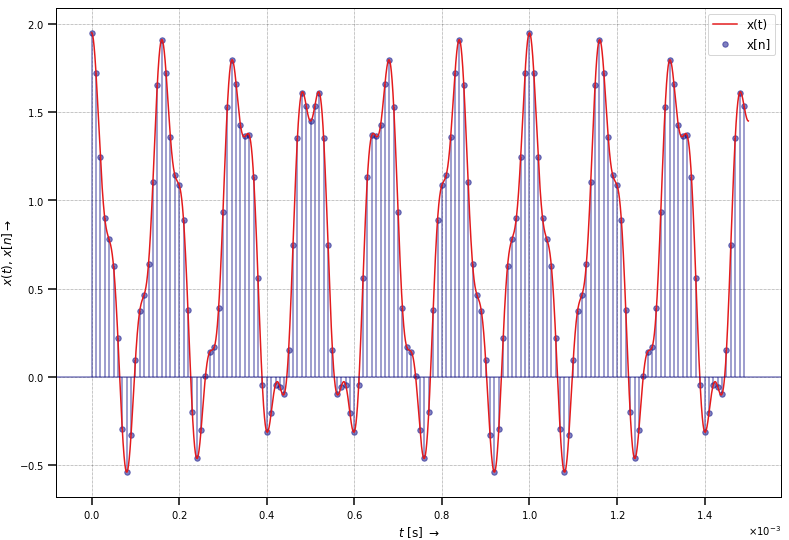

In [21]:
xt = x(t) # "analoges" Signal
fig1, ax1 = plt.subplots(**figsize)
ax1.plot(t,xt, label="x(t)")
stems(t[::OSR],xt[::OSR], ax=ax1, s=30, color=(0.0,0,0.5,0.5), label="x[n]") #"abgetastetes" Signal
ax1.set_xlabel(r'$t$ [s] $\rightarrow $');ax1.set_ylabel(r'$x(t),\, x[n] \rightarrow $'); ax1.legend();

# Fensterln
Aus einer periodischen (unendlichen) Datenfolge $x[n]$ schneiden wir wieder $N_{FFT}$ Datenpunkte im Zeitbereich aus und erhalten $x_w[n]$. Die DFT von $x_w[n]$ liefert uns $N_{FFT}$ Frequenzpunkte. **Wenn** die periodische Fortsetzung von $y_w[n]$ das ursprüngliche Signal $x[n]$ ergibt, d.h. wenn sich die $N_{FFT}$ Datenpunkte periodisch wiederholen, liefert die **DTFT** exakt das gleiche Ergebnis wie die DFT. Wir gehen jetzt davon aus, dass das nicht der Fall ist.

Zum sanften Ausblenden legen wir daher eine Fensterfunktion $w(t)$ bzw. $w[n]$ im Zeitbereich fest, deren Maximum 1 ist und die an den Enden des Fensters sanft gegen Null geht. Da alle Fensterfunktionen (außer dem Rechteckfenster) das Signal abschwächen, muss diese Dämpfung bei der Spektralanalyse korrigiert werden. Die entsprechenden Eigenschaften eines Fensters mit $N$ Punkten nennt man:

**Correlated Gain:** Mit diesem Faktor (der immer $\le 1$ ist) wird die *Amplitude* von periodischen (korrelierten) Signalkomponenten in der DFT gedämpft. Für eine korrekte Darstellung der Amplituden von Linienspektren muss man daher die DFT durch diesen Faktor dividieren, der der arithmetische Mittelwert des Fensters ist.

$$CGain = \frac{\sum_{n=0}^{N-1} w[n]}{N}$$

**Equivalent Noise Bandwidth:** Bei allen Fenstern außer dem Rechteckfenster werden Linien auf mehrere Frequenzpunkte "verschmiert", die Gesamtleistung des gefensterten Signals *steigt* daher an. Für die Bestimmung der Amplitude einzelner Spektralkomponenten spielt das keine Rolle, wohl aber wenn es z.B. um die Rauschleistung geht. Zur Berechnung nutzen wir die Äquivalenz von Energie / Leistung im Frequenz- und Zeitbereich (Parcevals Theorem). 

Man betrachtet das Fenster als Filter mit dem Betragsgang $|W(j \Omega)|$ mit weißem Rauschen am Eingang und der Gesamtrauschleistung $P_N$ am Ausgang

$$P_N = \frac 1 {T_1}\int_{-\pi}^{\pi} |W(j \Omega)|^2 d \Omega =  \frac 1 {T_1} \sum_{n=0}^{N-1}\left|W\Omega_n\right|^2 = \frac 1 N \sum_{n=0}^{N-1} w[n]^2$$

Um die Performance verschiedener Fensterfunktionen zu vergleichen, berechnet man die Bandbreite eines äquivalenten idealen Tiefpassfilters, das die gleiche Rauschleistung am Ausgang liefern würde. Dazu dividiert man die Rauschleistung durch das Quadrat des Maximums des Betragsgangs $W_{max}$. Bei DFT Fenstern ist das Maximum immer bei $\Omega = 0$ (entsprechend dem Correlated Gain) und lässt sich daher leicht berechnen:

$$W_{max} = W(j\Omega = 0) = \frac 1 N \sum_{n=0}^{N-1} w[n]$$

Damit erhält man die äquivalente Rauschbandbreite mit

$$ENBW = \frac {P_N}{W_{max}^2}= \frac{\sum w[n]^2}{N} \cdot \left(\frac{N}{\sum w[n]}\right)^2 = N \frac{\sum w[n]^2}{\left(\sum w[n]\right)^2}$$

In [22]:
def w(N): # Definiere Fensterfunktion
    if not np.isscalar(N):
        N = len(N) 
    #wn = sig.windows.boxcar(N); win_name ='Rechteck'; btm=-50
    wn = sig.windows.hann(N, sym = False); win_name ='Hann'; btm=-100
    #wn = sig.windows.hamming(N , sym = False); win_name ='Hamming'; btm=-100
    #wn = sig.windows.flattop(N, sym = False); win_name ='Flattop'; btm =-120
    # wn = sig.windows.bartlett(N, sym = False); win_name ='Bartlett'; btm=-70
    # Funktions Attribute zum Speichern von Fenstereigenschaften
    w.name = win_name                              # Name
    w.cgain = np.sum(wn)/N                         # Correlated Gain; Verstärkung für Liniensignale
    w.enbw = N * np.sum(wn**2)/ np.sum(wn)**2 # Äquivalente Rauschbandbreite (Verst. für Breitbandsignale)
    w.btm = btm # unteres Limit bei log. Darstellung, sinnvoller Wert hängt vom Fenster ab
    return wn
wn = w(1000) # Funktionsaufruf um Attribute zu definieren
print("{0} Fenster: CGain = {1:g}, ENBW = {2:g}".format(w.name,w.cgain,w.enbw))

Hann Fenster: CGain = 0.5, ENBW = 1.5


Im Zeitbereich wird das unendlich ausgedehnte Signal $x[n]$ mit der Fensterfunktion multipliziert, im Frequenzbereich entspricht das einer Faltung:

$$x_w[n] = x[n] \cdot w[n] \rightarrow X_w(j \Omega) = X(j\Omega) \ast W(j \Omega)$$

Abhängig vom gewählten Fenster sieht man wie sich die mit dem Fensterspektrum gefalteten Spektrallinien mehr oder weniger stark überlappen.

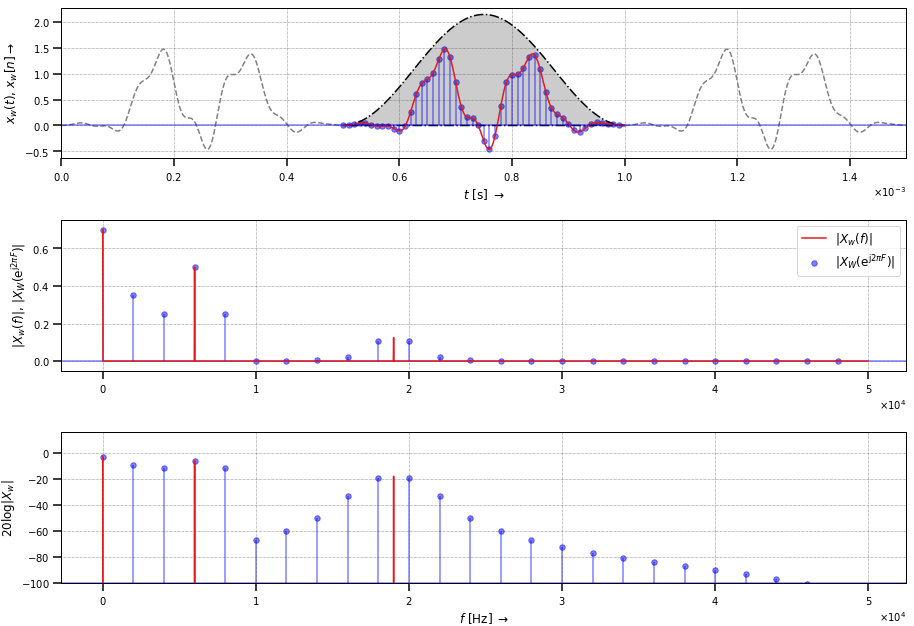

In [23]:
xtw = xt[N_FFT*OSR:2*N_FFT*OSR]*w(N_FFT*OSR)  # Schneide das analoge Signal aus und bewerte es mit der Fensterfunktion
xn = xtw[::OSR] # ... und taste es ab: Nimm nur jedes OSR'te Sample
#xtw = np.tile(xtw, L) # Wiederhole das analoge Signal L mal
tt = linspace(0,T_meas*100, N_FFT * 100, endpoint=False) # "analog" time for 100 windows giving a df = 1/(100T_meas)

fig2,ax2 = plt.subplots(nrows=3, ncols=1,**figsize)
ax2[0].plot(t[0:N_FFT*OSR], xtw, t[(2*N_FFT)*OSR:], xtw, color='grey', linestyle='--')
ax2[0].plot(t[N_FFT*OSR:(2*N_FFT)*OSR], xtw)
stems(t[N_FFT*OSR:2*N_FFT*OSR:OSR],xn, ax=ax2[0], s=30, color=(0.0,0,1,0.5)) # x[n]
ax2[0].fill_between(t[N_FFT*OSR:2*N_FFT*OSR], w(N_FFT*OSR)*np.max(xt)*1.1, facecolor = (0,0,0,0.2),
                  lw = 1.5, edgecolor = 'black', linestyle = '-.')
ax2[0].set_xlabel(r'$t$ [s] $\rightarrow $');ax2[0].set_ylabel(r'$x_w(t),\, x_w[n] \rightarrow $');
ax2[0].set_xlim(0, L*T_meas)
# ----- Spektrum ------
Xn = np.abs(fft(xn, N_FFT)) / (N_FFT * w.cgain) # Berechne / skaliere für zweiseitiges Spektrum
Xt = np.abs(fft(x(tt)))/len(tt)
#Xn[0] = Xn[0] / 2                           # korrigiere DC-Wert
#Xt[0] = Xt[0] / 2   
f =  fftfreq(len(Xn), T_S)                  # erzeuge N_FFT Freq.punkte bei [0... f_S/2[, [-f_S/2 ... f_s[]
fc = fftfreq(len(Xt), T_S)
stems(f[:N_FFT//2], Xn[:N_FFT//2], ax=ax2[1], s=30, color=(0.0,0,1,0.5), label=r"$|X_W(\mathrm{e}^{\mathrm{j} 2 \pi F})|$")
ax2[1].plot(fc[:len(tt)//2], Xt[:len(tt)//2], label=r"$|X_w(f)|$")
ax2[1].legend(loc='best'); ax2[1].set_ylabel(r'$|X_w(f)|, \,|X_W(\mathrm{e}^{\mathrm{j} 2 \pi F})|$')
# ----- log. Spektrum ------
stems(f[:N_FFT//2], 20*np.log10(Xn[:N_FFT//2]), ax=ax2[2], s=30, bottom=w.btm, color=(0.0,0,1,0.5))
ax2[2].plot(fc[:len(tt)//2], 20*np.log10(Xt[:len(tt)//2]))
ax2[2].set_xlabel(r'$f$ [Hz] $\rightarrow $'); ax2[2].set_ylabel(r'$20 \log|X_w|$'); ax2[2].set_ylim(bottom=w.btm)

fig2.tight_layout();

Man sieht, dass der Amplitudenfehler (Differenz zwischen rotem CFT Spektrum und blauem DFT-Punkt) bei Ton b geringer geworden ist, dass sich jetzt aber die DC-Linie und Ton A aufgrund des Leckeffekts gegenseitig beeinflussen.

Da das Fenster ein einmaliges Zeitsignal ist, ist das Spektrum (DTFT!) kontinuierlich im Bereich $0 \ldots f_S$. Je größer die Anzahl der DFT Punkte ist, desto schmaler ist das Fenster im Frequenzbereich. Die nächste Zelle plottet das Fenster im Zeitbereich und im Frequenzbereich, linear und logarithmisch skaliert. Im logarithmischen Plot sind die Frequenzpunkte der DFT markiert.

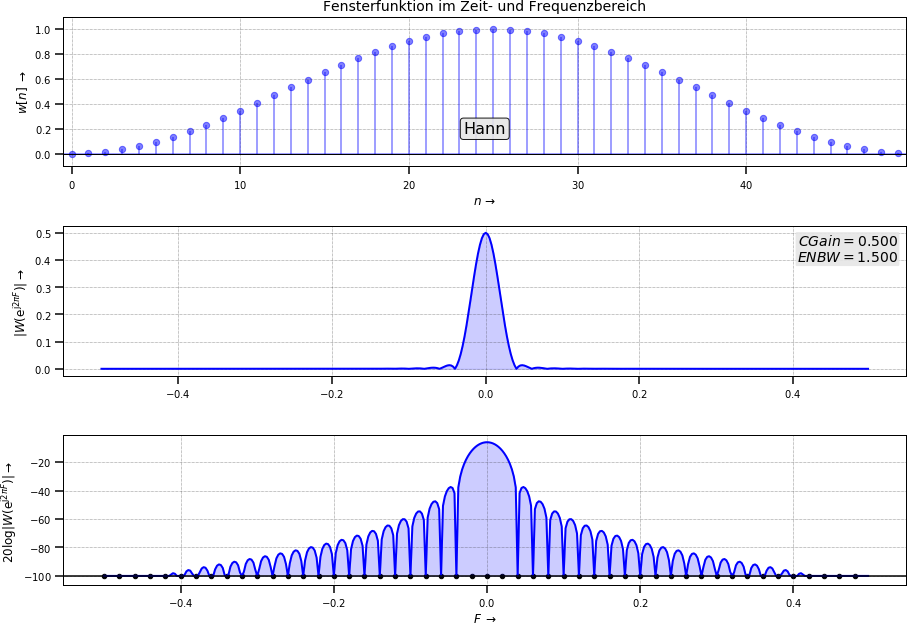

In [24]:
wn = w(N_FFT)
Wn = fftshift(fft(wn, N_FFT*8))/N_FFT # Zero padding für schönere Fensterfunktion
Wnlog = np.maximum(20 * log10(abs(Wn)), w.btm)
wf = fftshift(fftfreq(N_FFT*8))
#
fig3,ax3 = plt.subplots(nrows=3, ncols=1, **figsize)
ax3[0].set_title('Fensterfunktion im Zeit- und Frequenzbereich')
stems(n[:N_FFT],wn, ax3[0], color=(0.0,0,1,0.5))#ax3[0].stem(wn)
ax3[0].text(0.5, 0.2, w.name, fontsize=16,
         ha="center", va="bottom", transform = ax3[0].transAxes,
         bbox=dict(alpha=0.9,boxstyle="round,pad=0.2", fc='0.9'))
ax3[0].set_xlabel(r'$n \, \rightarrow $'); ax3[0].set_ylabel(r'$w[n] \; \rightarrow $')
ax3[0].set_xlim(-0.5, N_FFT - 0.5); ax3[0].set_ylim(-0.1, 1.1)
ax3[0].axhline(0, xmin = 0, xmax = 1, linewidth=1, color='k')
# Window Spektrum (linear scale)
ax3[1].plot(wf, abs(Wn), lw = 2, color = 'b')
ax3[1].fill_between(wf, abs(Wn), alpha = 0.2, color='b')
ax3[1].set_ylabel(r'$\| W(\mathrm{e}^{\mathrm{j} 2 \pi F})\| \rightarrow $ ')
ax3[1].text(0.99, 0.95, '$CGain = %0.3f$\n$ENBW = %0.3f$'%(w.cgain,w.enbw), fontsize=14,
         ha="right", va="top", transform = ax3[1].transAxes,
         bbox=dict(alpha=0.9,boxstyle="round,pad=0.1", fc='0.9', lw = 0) )
# Fensterspektrum (log scale)
ax3[2].plot(wf, Wnlog, lw = 2, color = 'b')
stems(n[:N_FFT]/N_FFT-0.5,w.btm*np.ones(N_FFT),ax3[2], s=20, color='k', bottom=w.btm)
ax3[2].fill_between(wf, Wnlog, w.btm, alpha = 0.2, color='b')
ax3[2].set_ylabel(r'$ 20\log| W(\mathrm{e}^{\mathrm{j} 2 \pi F})| \rightarrow $ ')
ax3[2].set_xlabel(r'$F \; \rightarrow $')

fig3.tight_layout();

Im Folgenden werden die Töne und die DC-Komponente einzeln mit der Fensterfunktion gefaltet und dargestellt:

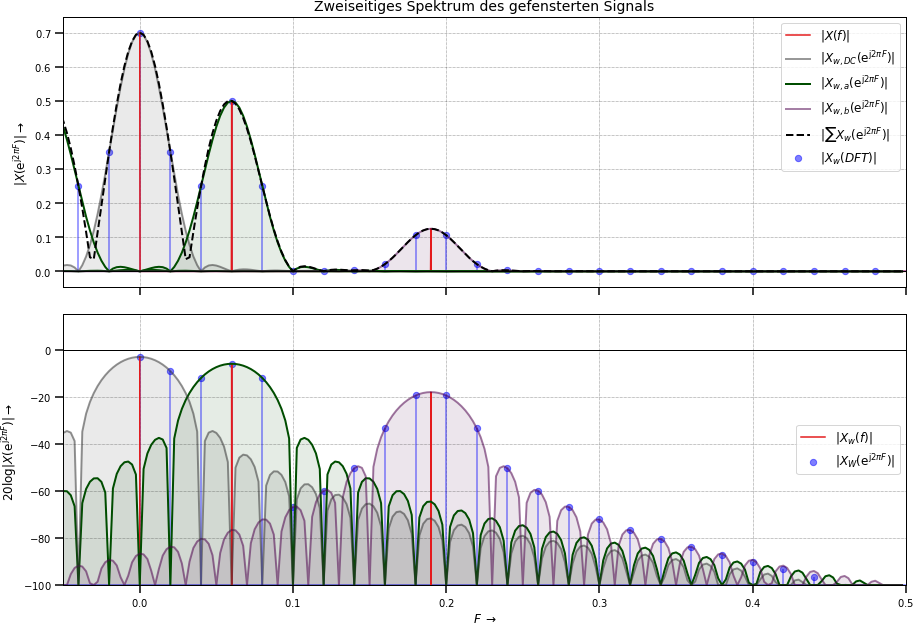

In [25]:
wn = w(N_FFT)
F_str = r"\mathrm{e}^{\mathrm{j} 2 \pi F}" # LaTeX string mit komplexer Frequenz
Omg_a = 2*np.pi*f_a/f_S; Omg_b = 2*np.pi*f_b/f_S;
Xn_a = A_a/w.cgain*fftshift(fft(wn*np.exp(1j*Omg_a*n[:N_FFT]), N_FFT*8))/N_FFT/2 # Zero padding für schönere Fenster
Xn_am = A_a/w.cgain*fftshift(fft(wn*np.exp(-1j*Omg_a*n[:N_FFT]), N_FFT*8))/N_FFT/2 # Zero padding für schönere Fenster
Xn_a_log = np.maximum(20 * log10(abs(Xn_a)), w.btm)
Xn_b = A_b/w.cgain*fftshift(fft(wn*np.exp(1j*Omg_b*n[:N_FFT]), N_FFT*8))/N_FFT/2 # Zero padding für schönere Fenster
Xn_b_log = np.maximum(20 * log10(abs(Xn_b)), w.btm)
Xn_dc = DC/w.cgain*fftshift(fft(wn, N_FFT*8))/N_FFT # Zero padding für schönere Fenster
Xn_dc_log = np.maximum(20 * log10(abs(Xn_dc)), w.btm)
wf = fftshift(fftfreq(N_FFT*8))
#
# Window Spektrum (linear scale)
fig4,ax4 = plt.subplots(nrows=2, ncols=1, sharex=True, **figsize)
ax4[0].set_title('Zweiseitiges Spektrum des gefensterten Signals')
stems(f/f_S, Xn, ax=ax4[0], color=(0.0,0,1,0.5), label=r"$|X_w(DFT)|$") # DFT
ax4[0].plot(fc[:len(tt)//2]/f_S, Xt[:len(tt)//2], label=r"$|X(f)|$") # CFT

ax4[0].plot(wf, abs(Xn_dc), lw = 2, color=c3, alpha=0.5, label=r"$|X_{{w,DC}}({0})|$".format(F_str))
ax4[0].plot(wf, abs(Xn_a), lw = 2, color=c1, label=r"$|X_{{w,a}}({0})|$".format(F_str))
ax4[0].plot(wf, abs(Xn_am), lw = 2, color=c1)
ax4[0].plot(wf, abs(Xn_b), lw = 2, color=c2, alpha=0.5, label=r"$|X_{{w,b}}({0})|$".format(F_str))

ax4[0].plot(wf, abs(Xn_a + Xn_am + Xn_b + Xn_dc), lw = 2, color="black", linestyle='--',
            label=r"$|\sum X_{{w}}({0})|$".format(F_str))
ax4[0].fill_between(wf, abs(Xn_a), color=c1, alpha=0.1)
ax4[0].fill_between(wf, abs(Xn_b), color=c2, alpha=0.1)
ax4[0].fill_between(wf, abs(Xn_dc), color=c3, alpha=0.1)
ax4[0].set_ylabel(r'$\| X(\mathrm{e}^{\mathrm{j} 2 \pi F})\| \rightarrow $ ')
ax4[0].axhline(0, xmin = 0, xmax = 1, linewidth=1, color='k')
ax4[0].legend(loc='best'); ax2[1].set_ylabel(r'$|X_w(f)|, \,|X_W(\mathrm{e}^{\mathrm{j} 2 \pi F})|$')
# Fensterspektrum (log scale)
stems(f[:N_FFT//2]/f_S, 20*log10(abs(Xn[:N_FFT//2])), ax=ax4[1], bottom=w.btm, color=(0.0,0,1,0.5), 
      label=r"$|X_W(\mathrm{e}^{\mathrm{j} 2 \pi F})|$")
ax4[1].plot(fc[:len(tt)//2]/f_S, 20*log10(abs(Xt[:len(tt)//2])), label=r"$|X_w(f)|$")
ax4[1].legend(loc='best'); ax2[1].set_ylabel(r'$|X_w(f)|, \,|X_W(\mathrm{e}^{\mathrm{j} 2 \pi F})|$')
ax4[1].plot(wf, Xn_a_log, lw = 2, color=c1)
ax4[1].plot(wf, Xn_b_log, lw = 2, color =c2, alpha=0.5)
ax4[1].plot(wf, Xn_dc_log, lw = 2, color=c3, alpha=0.5)
ax4[1].fill_between(wf, Xn_a_log, w.btm, color=c1, alpha=0.1)
ax4[1].fill_between(wf, Xn_b_log, w.btm, color=c2, alpha=0.1)
ax4[1].fill_between(wf, Xn_dc_log, w.btm, color=c3, alpha=0.1)
ax4[1].set_ylabel(r'$\| 20 \log X(\mathrm{e}^{\mathrm{j} 2 \pi F})\| \rightarrow $ ')
ax4[1].axhline(0, xmin = 0, xmax = 1, linewidth=1, color='k')
ax4[1].set_xlim(-0.05, 0.5); ax4[1].set_ylim(bottom=w.btm)

ax4[1].set_ylabel(r'$ 20\log| X(\mathrm{e}^{\mathrm{j} 2 \pi F})| \rightarrow $ ')
ax4[1].set_xlabel(r'$F \; \rightarrow $')

fig4.tight_layout();

## Fragen und Experimente
* Spielen Sie mit verschiedenen Fenstern herum, beobachten Sie die unterschiedlichen Frequenzauflösungen, Amplitudenfehler und Leckeffekte.
* Bei Verwendung eines Flattop-Fensters weichen die DFT-Werte für DC und $f_a = 3 \Delta f$ mehr als 20\% von den CFT-Werten ab. Woran könnte das liegen?

### Weiterlesen:
Sehr empfohlen sind die exzellenten Notebooks unter
* https://github.com/unpingco/Python-for-Signal-Processing/blob/master/Windowing.ipynb
* https://github.com/unpingco/Python-for-Signal-Processing/blob/master/Windowing_Part2.ipynb
* https://github.com/unpingco/Python-for-Signal-Processing/blob/master/Windowing_Part3.ipynb

Statische Ansicht unter https://github.com/unpingco/Python-for-Signal-Processing


***
**Copyright**

(c) 2016 - 2019 Prof. Dr. Christian Münker 

This jupyter notebook is part of a collection of notebooks on various topics of Digital Signal Processing. The latest version can be found at https://github.com/chipmuenk/dsp_fpga "Digitale Signalverarbeitung auf FPGAs"

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Christian Münker, Digital Signal Processing auf FPGAs - Vorlesungsunterlagen mit Simulationsbeispielen, 2018*.